#  Forecasting taxi orders

The Clear Taxi company has collected historical data on taxi orders at airports. To attract more drivers during the peak period, you need to predict the number of taxi orders for the next hour. Build a model for such a prediction.

The value of the *RMSE* metric on the test set should not exceed 48.

You need:

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.


The data is in the `taxi.csv` file. The number of orders is in the `num_orders` column.

<font size=3><b>Project steps</b></font>

1. Load the data and resample it one hour at a time.
2. Analyze the data.
3. Train different models with different hyperparameters. Make a test sample of 10% of the original data.
4. Check the data on the test sample and draw conclusions.

## Data preparation

In [1]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [2]:
#load the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import warnings
warnings.filterwarnings('ignore')

In [3]:
#save the dataset and set the table index to the datetime column
try:
    df_taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
except Exception:
    print("Some other exception")

In [4]:
#sort the table index and get acquainted with the dataset
df_taxi.sort_index(inplace=True)
df_taxi.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


There are only 2 columns in the dataset - with the date and the number of orders. Let's check the data types.

In [5]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


The data types are correct: a column with a date in the `Datetime` format, a column with the number of orders `num_orders` in the `int64` format. The dataset contains data from 00:00 on March 1, 2018 to 23:50 on August 31, 2018. There are no gaps in the dataset.

In [6]:
#check if the dataset is ordered by index
print(df_taxi.index.is_monotonic)

True


The dataset is ordered by index, you can start the analysis.

## Data analysis

At this stage, we will resample the dataset for 1 hour, and also look at the trends and seasonality of the dataset.

In [7]:
#resampling
df_taxi = df_taxi.resample('1H').sum()

The number of rows should decrease by 6 times, since before that there was an unloading every 10 minutes. Let's check.

In [8]:
df_taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Yes, the number of lines has decreased by 6 times. Now let's look at trends and seasonality.

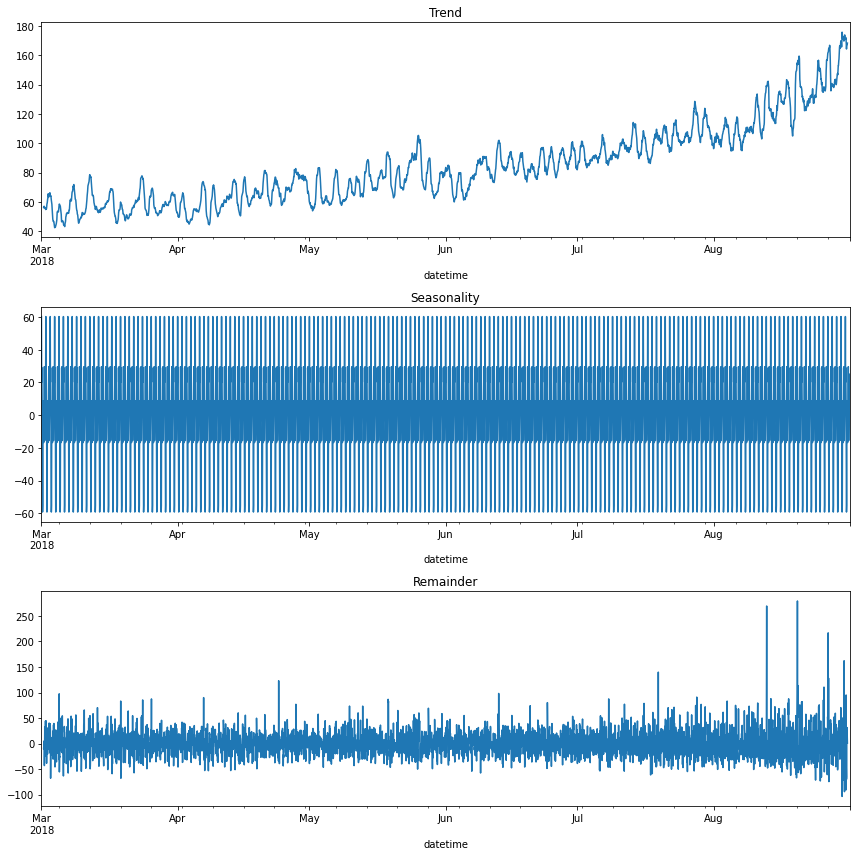

In [9]:
decomposed = seasonal_decompose(df_taxi)

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Remainder')
plt.tight_layout()

According to the trend, we can see that the number of taxi orders has been continuously increasing since June. In terms of seasonality, nothing is clear, let's take a period of time for the last month of the sample - August.

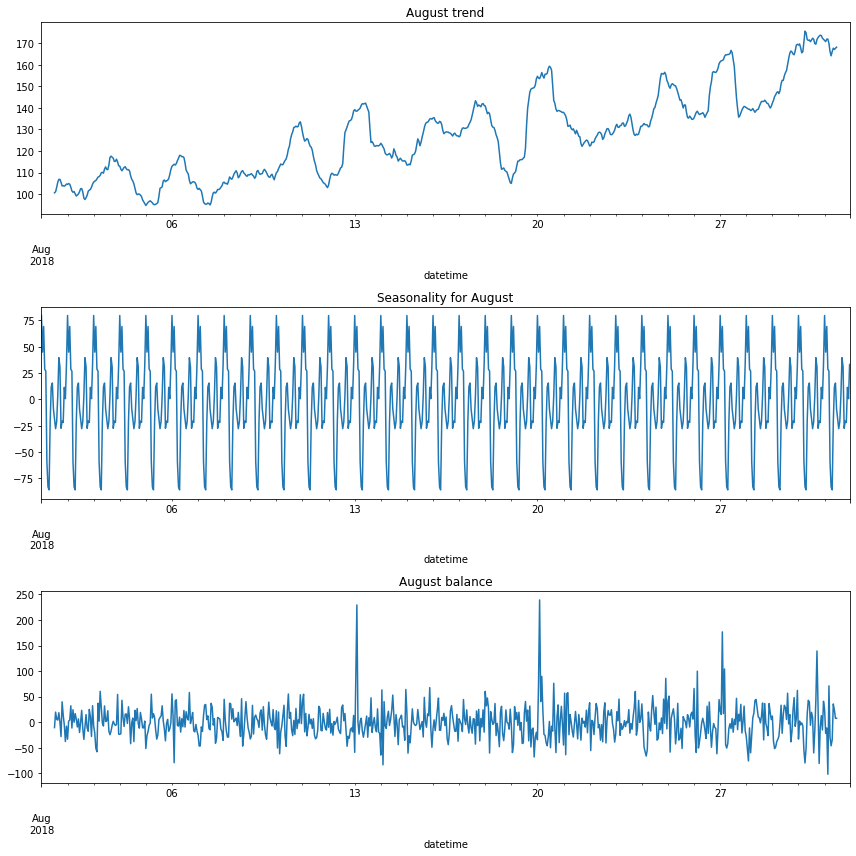

In [10]:
decomposed_aug = seasonal_decompose(df_taxi['2018-08-01':'2018-08-31'])

plt.figure(figsize=(12, 12))

plt.subplot(311)
decomposed_aug.trend.plot(ax=plt.gca())
plt.title('August trend')

plt.subplot(312)
decomposed_aug.seasonal.plot(ax=plt.gca())
plt.title('Seasonality for August')

plt.subplot(313)
decomposed_aug.resid.plot(ax=plt.gca())
plt.title('August balance')
plt.tight_layout()

We also see an increase in the trend throughout August, and seasonality again shows complete stability, like an astronaut's cardiogram. Consider the seasonality in the context of one day, so that you can draw some conclusions.

Text(0.5, 1.0, 'Seasonality per day')

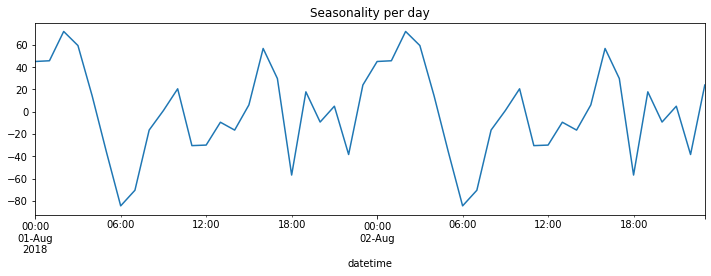

In [11]:
decomposed_day = seasonal_decompose(df_taxi['2018-08-01':'2018-08-02'])
plt.figure(figsize=(12, 12))
plt.subplot(312)
decomposed_day.seasonal.plot(ax=plt.gca())
plt.title('Seasonality per day')

Now you can see better that at 6 am the increase in the number of orders begins, then a sharp drop in the number of orders from 11 am to 12 pm, then again an increase in the number of orders until 4 pm, then again a fall, and then an increase in the number of orders from 6 pm to 2 hours of the night, after which there is a sharp decrease in orders and at 6 am a new cycle begins. The peak of orders falls on the time period from 0 to 2 am.

## Training

### Feature preparation

Let's prepare our dataset for working with models. For this we:
1. Let's create additional features for the dataset.
2. Let's create a constant model to test our models for adequacy.
3. Let's prepare the training and test sets in the ratio of 9:1.

Let's create new features for the dataset:
1. Calendar features (month, day, day of the week).
2. Lagging values.
3. Moving average.

In [12]:
#create a function for calculating RMSE
def rmse(target, prediction):
    return mean_squared_error(target, prediction)**0.5

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy(deep=True)
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

#take arbitrary values
df = make_features(df_taxi, 30, 40)

In [14]:
#check new dataset
df.sample(10)

,num_orders,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-06-21 05:00:00,40,6,21,3,110.0,124.0,97.0,118.0,134.0,107.0,...,24.0,95.0,52.0,115.0,93.0,137.0,95.0,126.0,86.0,87.375
2018-07-27 05:00:00,64,7,27,4,109.0,131.0,161.0,108.0,222.0,117.0,...,39.0,21.0,83.0,131.0,141.0,197.0,73.0,149.0,138.0,108.675
2018-04-25 08:00:00,58,4,25,2,27.0,6.0,38.0,38.0,52.0,68.0,...,74.0,58.0,54.0,17.0,2.0,36.0,28.0,76.0,83.0,63.425
2018-04-11 01:00:00,49,4,11,2,99.0,79.0,52.0,53.0,58.0,71.0,...,47.0,45.0,51.0,88.0,66.0,72.0,46.0,57.0,62.0,58.200
2018-08-29 16:00:00,220,8,29,2,163.0,196.0,135.0,167.0,179.0,183.0,...,113.0,211.0,148.0,184.0,134.0,113.0,131.0,141.0,183.0,141.200
2018-04-13 08:00:00,60,4,13,4,38.0,9.0,26.0,59.0,73.0,39.0,...,103.0,78.0,67.0,5.0,2.0,3.0,30.0,72.0,76.0,61.675
2018-06-15 10:00:00,122,6,15,4,74.0,69.0,27.0,26.0,79.0,103.0,...,101.0,63.0,94.0,84.0,66.0,31.0,19.0,36.0,117.0,82.900
2018-05-17 12:00:00,62,5,17,3,92.0,92.0,91.0,61.0,27.0,2.0,...,65.0,73.0,43.0,83.0,76.0,77.0,62.0,33.0,20.0,74.625
2018-07-31 22:00:00,124,7,31,1,131.0,98.0,85.0,42.0,112.0,100.0,...,179.0,101.0,111.0,122.0,76.0,125.0,78.0,156.0,127.0,101.400


Let's check the RMSE on two constant models: the median forecast and the forecast of the previous value of the series.

In [15]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

#constant model predicting the median
pred_median = np.ones(test.shape) * train['num_orders'].median()
rmse_median = mean_squared_error(test, pred_median)**0.5
print("RMSE of a constant model predicting the median:", rmse_median)

#constant model that predicts the previous value of the series
pred_previous = pd.Series(train['num_orders'].iloc[-len(test):])
print("RMSE of a constant model predicting the previous value of the series:",
      rmse(test['num_orders'], pred_previous))

RMSE of a constant model predicting the median: 84.54772153207533
RMSE of a constant model predicting the previous value of the series: 81.82849573915023


In [16]:
#prepare training and test sets
features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']

features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']
print('Training sample size:', features_train.shape)
print('Test sample size:', features_test.shape)

Training sample size: (3934, 34)
Test sample size: (442, 34)


We can start training models.

### Linear regression

In [17]:
#here we use standard parameters

linear_model = LinearRegression()
linear_model.fit(features_train, target_train)
 
linear_prediction = linear_model.predict(features_train)
print('The RMSE of linear regression is:', rmse(target_train, linear_prediction))

The RMSE of linear regression is: 25.162063268252812


Linear regression showed a very good RMSE result of 25.16. Let's see what more complex models show.

### Random Forest

In [18]:
tss = TimeSeriesSplit(n_splits = 5)

forest_model = RandomForestRegressor(random_state=12345)
forest_params = {'n_estimators':range(10, 50, 10), 'max_depth':range(10, 20)}
forest_grid = GridSearchCV(forest_model, forest_params, cv=tss, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
forest_grid.fit(features_train, target_train)
forest_prediction = forest_grid.predict(features_train)

print('Best Random Forest parametres:', forest_grid.best_params_)
print('The RMSE of a random forest is:', rmse(target_train, forest_prediction))

Best Random Forest parametres: {'max_depth': 17, 'n_estimators': 40}
The RMSE of a random forest is: 9.437120311120644


The RMSE of the random forest on the training set was 9.43.

### Catboost

In [19]:
cat_model = CatBoostRegressor(iterations=100, verbose=False, random_state=12345)
cat_params = {'learning_rate':[0.1, 0.2],
              'depth':[10, 15, 20]}
cat_grid = GridSearchCV(cat_model, cat_params, cv=tss, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
cat_grid.fit(features_train, target_train)
cat_prediction = cat_grid.predict(features_train)

print('Best Catboost parametres:', cat_grid.best_params_)
print('RMSE Catboost is:', rmse(target_train, cat_prediction))

Best Catboost parametres: {'depth': 10, 'learning_rate': 0.1}
RMSE Catboost is: 14.407305245937813


Catboost showed a worse RMSE result than the forest: 14.40.

### LightGBM

In [20]:
gbm_model = LGBMRegressor(random_state=12345)
gbm_params = {'n_estimators':[100, 150],
              'num_leaves':[10, 15, 20]}
gbm_grid = GridSearchCV(gbm_model, gbm_params, cv=tss, scoring = 'neg_root_mean_squared_error', n_jobs=-1)
gbm_grid.fit(features_train, target_train)
gbm_prediction = gbm_grid.predict(features_train)

print('Best params LightGBM OE:', gbm_grid.best_params_)
print('RMSE LightGBM is:', rmse(target_train, gbm_prediction))

Best params LightGBM OE: {'n_estimators': 150, 'num_leaves': 10}
RMSE LightGBM is: 16.947848800689265


LightGBM performed even worse than random forest and Catboost and its RMSE was 16.94.

### Conclusion by models

1. All 4 models showed an RMSE result below 48.
2. The best result was demonstrated by random forest and Catboost, and we will check them on the test sample.

## Testing

Let's create a comparison table with the RMSE results.

In [21]:
data={'Model': ['Linear Regression', 'RandomForest', 'CatBoost', 'LightGBM', 'Constant Median', 'Constant Previous'],
      'RMSE': [25.16, 9.43, 14.40, 16.94, 84.54, 81.82]}
data_pivot=pd.DataFrame.from_dict(data)
display(data_pivot)

,Model,RMSE
0,Linear Regression,25.16
1,RandomForest,9.43
2,CatBoost,14.40
3,LightGBM,16.94
4,Constant Median,84.54
5,Constant Previous,81.82


Let's check the RMSE of the random forest and Catboost on the test set.

In [22]:
forest = RandomForestRegressor(random_state=12345, max_depth=17, n_estimators=40)
forest.fit(features_train, target_train)
forest_pred = forest.predict(features_test)
print('The RMSE of the random forest on the test set is:', rmse(target_test, forest_pred))

The RMSE of the random forest on the test set is: 43.78905280006859


In [23]:
catboost = CatBoostRegressor(iterations=100, verbose=False, random_state=12345,
                            learning_rate=0.1, depth=10)
catboost.fit(features_train, target_train)
catboost_pred = catboost.predict(features_test)
print('RMSE Catboost on the test set is:', rmse(target_test, catboost_pred))

RMSE Catboost on the test set is: 46.54525607876236


On the test set, RMSE turned out to be several times worse than on the training set, but all the same, the models met the RMSE threshold up to 48. The best result showed a random forest with a score of 43.78.

Let's look at the graph of the importance of factors.

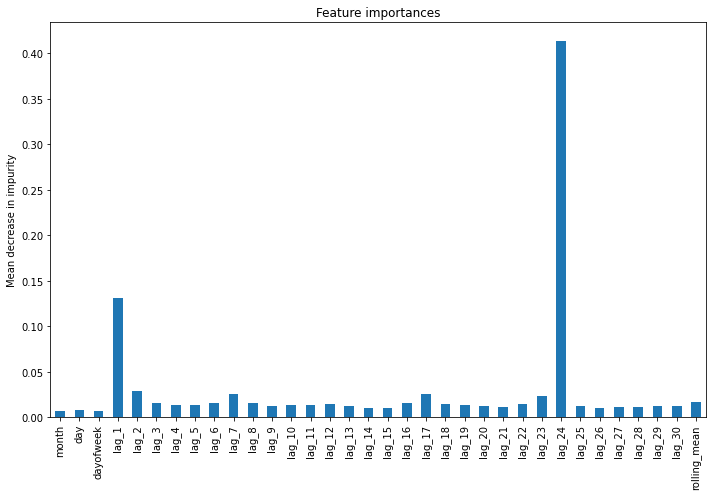

In [24]:
feature_names = features_train.columns 
model = RandomForestRegressor(n_estimators=40, max_depth=18, random_state=12345)
model.fit(features_train, target_train)
pred = model.predict(features_test)
importances = model.feature_importances_
model_importances = pd.Series(importances, index=feature_names)

std = np.std([model.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
model_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

And let's see on the graph how the predictions of the model correlate with the actual data from the unloading of orders.

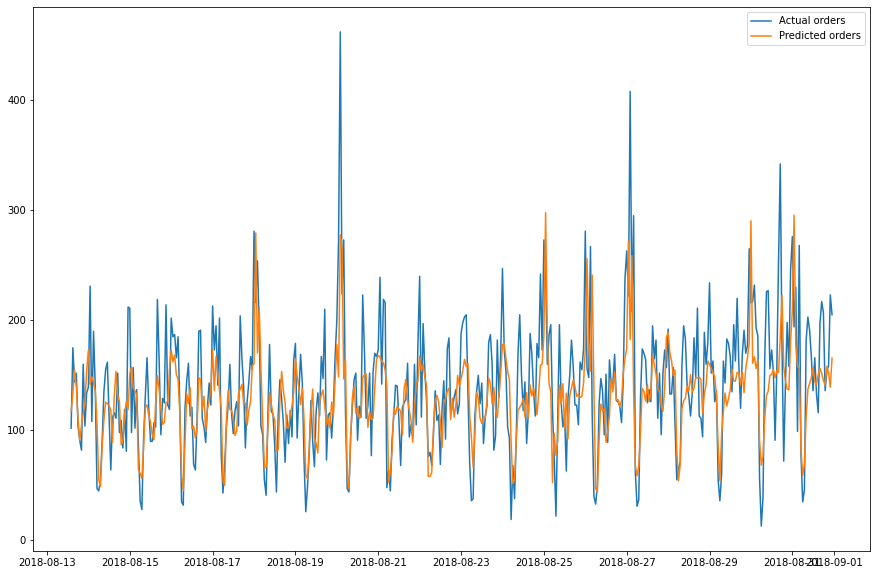

In [25]:
plt.figure(figsize=(15, 10))
plt.plot(features_test.index, target_test, label='Actual orders')
plt.plot(features_test.index, forest_pred, label='Predicted orders')
plt.legend()
plt.show()

The graph shows that the model as a whole copes well with predictions, with the exception of rare large peaks.

## Conclusion

1. There are only 2 columns in the dataset - with the date and the number of orders. The data types are correct: a column with a date in the Datetime format, a column with the number of orders num_orders in the int64 format. The dataset contains data from 00:00 on March 1, 2018 to 23:50 on August 31, 2018. There are no gaps in the dataset. The dataset is ordered by index, you can start the analysis.
2. The dataset was resampled for 1 hour. The trend shows that the number of taxi orders has been continuously increasing since June. According to seasonality, it can be seen that the peak of orders falls on the time period from 0 to 2 am.
3. When preparing a dataset for working with models:
    1. Additional features were created for the dataset: month, day, day of the week, lagging values, moving average.
    2. A constant model has been created to test our models for adequacy.
    3. Prepared training and test samples in the ratio of 9:1.
4. The RMSE of the constant model predicting the median was 84.54772153207533. The RMSE of the constant model predicting the previous value of the series was 81.82849573915023.
5. 4 models were trained, which showed the following results on the training set.
    1. The RMSE of the linear regression is 25.16.
    2. The RMSE of the random forest on the training set was 9.43.
    3. RMSE Catboost was 14.40.
    4. LightGBM performed worse than Random Forest and Catboost and its RMSE was 16.94.
6. To test RMSE on a test sample, 2 models were selected:
    1. The RMSE of the random forest on the test set was 43.78.
    2. RMSE Catboost on the test set was 46.54.
7. A random forest was chosen as the main model for production.
8. Both tested models did not exceed the RMSE threshold of 48 in the test sample.